## Implementing softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a multi-class logistic regression, or softmax regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. This process involves writing vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

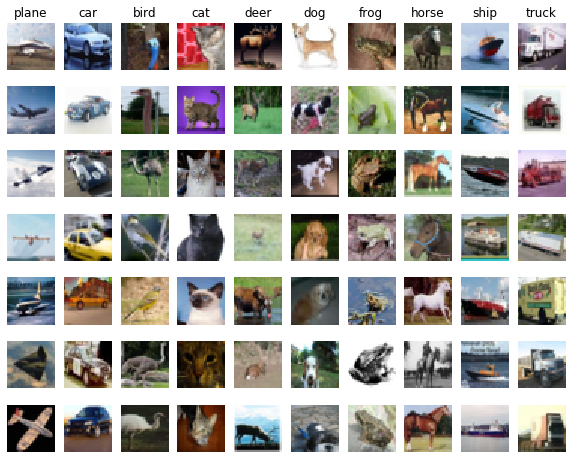

Training data shape: 49000,3072
Validation data shape: 1000,3072
Test data shape: 10000,3072
Training data shape with bias term: 49000,3073
Validation data shape with bias term: 1000,3073
Test data shape with bias term: 10000,3073


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=0}^{d}\sum_{k=1}^{K} {{\theta_j}^{(k)}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [5]:
from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.32

print ('loss: (should be close to 2.32): ', loss)

loss: (should be close to 2.32):  2.3205842073261125


## Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [6]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: %e computed in %f s' % (loss_naive, toc - tic))

numerical: -1.849043 analytic: -1.849043, relative error: 1.048034e-08
numerical: 0.371582 analytic: 0.371582, relative error: 1.832922e-08
numerical: 0.392464 analytic: 0.392464, relative error: 2.323590e-07
numerical: 1.559163 analytic: 1.559163, relative error: 1.406921e-08
numerical: 0.741648 analytic: 0.741648, relative error: 3.423347e-09
numerical: -0.499988 analytic: -0.499988, relative error: 3.648106e-08
numerical: 0.686270 analytic: 0.686270, relative error: 2.299748e-08
numerical: 0.549346 analytic: 0.549346, relative error: 3.967427e-08
numerical: 1.379842 analytic: 1.379842, relative error: 1.663134e-08
numerical: -0.186492 analytic: -0.186492, relative error: 1.692926e-07
naive loss: 2.320584e+00 computed in 8.881241 s


## Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %f s' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

vectorized loss: 2.320584e+00 computed in 0.529583 s
Loss difference: 0.000000
Gradient difference: 0.000000


## Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

## Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model = linear_classifier.Softmax()
for l in learning_rates:
    for reg in regularization_strengths:
        model.train(X_train, y_train, learning_rate=l, reg=reg, num_iters=600, batch_size=400, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        results[l, reg] = {train_accuracy, val_accuracy}
# model.train(X_train, y_train, learning_rate=5e-6, reg=1e8, num_iters=4000, batch_size=400, verbose=True)
# train_accuracy = np.mean(model.predict(X_train) == y_train)
# val_accuracy = np.mean(model.predict(X_val) == y_val)
# results[l, reg] = {train_accuracy, val_accuracy}
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 600: loss 8.388929
iteration 100 / 600: loss 5.918235
iteration 200 / 600: loss 5.499395
iteration 300 / 600: loss 5.237051
iteration 400 / 600: loss 5.118234
iteration 500 / 600: loss 4.827904
iteration 0 / 600: loss 6.768999
iteration 100 / 600: loss 6.781931
iteration 200 / 600: loss 6.581921
iteration 300 / 600: loss 6.619668
iteration 400 / 600: loss 6.439092
iteration 500 / 600: loss 6.178191
iteration 0 / 600: loss 20.728587
iteration 100 / 600: loss 20.175265
iteration 200 / 600: loss 19.683381
iteration 300 / 600: loss 18.976347
iteration 400 / 600: loss 18.727771
iteration 500 / 600: loss 18.394600
iteration 0 / 600: loss 3081.803670
iteration 100 / 600: loss 21.667365
iteration 200 / 600: loss 2.330359
iteration 300 / 600: loss 2.213569
iteration 400 / 600: loss 2.213759
iteration 500 / 600: loss 2.206484
iteration 0 / 600: loss 2.148043
iteration 100 / 600: loss 1.870535
iteration 200 / 600: loss 1.772426
iteration 300 / 600: loss 1.816160
iteration 400 / 600:

In [14]:
# lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.413449 val accuracy: 0.415000
# best validation accuracy achieved during cross-validation: 0.415000

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=4000, batch_size=400, verbose=True)
train_accuracy = np.mean(model.predict(X_train) == y_train)
val_accuracy = np.mean(model.predict(X_val) == y_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
print(f'for learning rate = 5e-7 and regularization term = 5e+5, train_accuracy is{train_accuracy}, validation accuracy is {val_accuracy}')

iteration 0 / 4000: loss 1.848773
iteration 100 / 4000: loss 1.780799
iteration 200 / 4000: loss 1.764361
iteration 300 / 4000: loss 1.728328
iteration 400 / 4000: loss 1.760659
iteration 500 / 4000: loss 1.835679
iteration 600 / 4000: loss 1.799554
iteration 700 / 4000: loss 1.777362
iteration 800 / 4000: loss 1.887120
iteration 900 / 4000: loss 1.720577
iteration 1000 / 4000: loss 1.771507
iteration 1100 / 4000: loss 1.754990
iteration 1200 / 4000: loss 1.780850
iteration 1300 / 4000: loss 1.703981
iteration 1400 / 4000: loss 1.814014
iteration 1500 / 4000: loss 1.800082
iteration 1600 / 4000: loss 1.791327
iteration 1700 / 4000: loss 1.774777
iteration 1800 / 4000: loss 1.720526
iteration 1900 / 4000: loss 1.773126
iteration 2000 / 4000: loss 1.848518
iteration 2100 / 4000: loss 1.752884
iteration 2200 / 4000: loss 1.815556
iteration 2300 / 4000: loss 1.832711
iteration 2400 / 4000: loss 1.699935
iteration 2500 / 4000: loss 1.829235
iteration 2600 / 4000: loss 1.809801
iteration 270

## Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

In [15]:
best_softmax = linear_classifier.Softmax()
best_softmax.train(X_train, y_train, learning_rate= 5e-7, reg= 5e5, num_iters=4000, batch_size=400, verbose=False)

[25.518005917948546,
 25.083332844237987,
 24.85296414878522,
 24.566129815890797,
 24.496778044722504,
 24.328070635564856,
 24.520637072819902,
 23.89642836452343,
 23.89226553813337,
 23.664051213672828,
 23.682061455714074,
 23.520703833254135,
 23.470661806435587,
 23.564756918722377,
 23.12352363101985,
 23.479617412704517,
 23.07041543824308,
 23.19396360087246,
 22.95032832293286,
 22.94970019672671,
 22.95579278019892,
 22.913699102591448,
 22.61635084861361,
 22.64369094273064,
 22.58945051294903,
 22.417169334192813,
 22.48249954096005,
 22.21167323493037,
 22.505960187677875,
 22.52720499149307,
 22.265176956079504,
 22.401532809654572,
 22.260561281118402,
 22.019664327252823,
 22.417795196452964,
 22.23347960440939,
 22.235054649138267,
 22.184293319596346,
 22.013221443744417,
 22.066423733456716,
 21.964586177744835,
 22.01855521880358,
 21.77828189735976,
 21.676722002925562,
 21.721510154605664,
 21.60619262150481,
 21.738605194781417,
 21.578904870029422,
 21.7698416

softmax on raw pixels final test set accuracy: 0.400400
[[514  55  38  23  13  19  27  38 190  83]
 [ 72 484  18  35  18  36  47  38  92 160]
 [123  51 204  81 114  91 183  67  56  30]
 [ 62  71  78 246  36 192 145  54  44  72]
 [ 66  40 111  50 279  93 200 100  33  28]
 [ 52  43  80 132  57 349 108  80  68  31]
 [ 23  54  59  91  69  84 519  33  23  45]
 [ 61  48  54  54  88  79  65 405  49  97]
 [181  77   8  18   7  52  12  12 521 112]
 [ 69 178  11  24  13  18  48  47 109 483]]


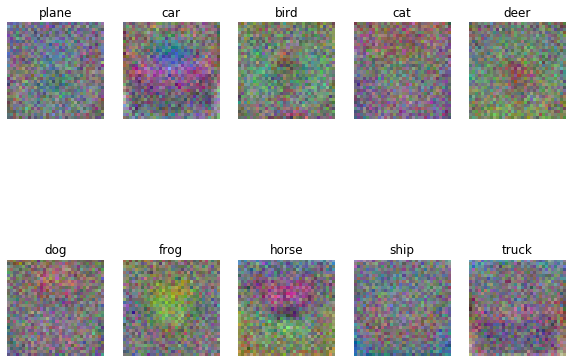

In [16]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_test_pred))

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.savefig('vis77.png')
plt.show()

## Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? 

In [17]:
import linear_classifier
import pandas as pd

df_batch = pd.DataFrame()
df_iter = pd.DataFrame()
model = linear_classifier.Softmax()
results = {}
best_val = -1
best_softmax = None
batch_sizes = [i for i in range(200, 2000, 300)]
iter_numbers = [i for i in range(1000, 5000, 1000)]
for it in iter_numbers:
    df_iter[f'{it}'] = pd.Series(0)
for batch in batch_sizes:
    df_batch[f'{batch}'] = pd.Series(0)

for batch in batch_sizes:
    best = 0
    for it in iter_numbers:
        model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=it, batch_size=batch, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        test_accuracy = np.mean(model.predict(X_test) == y_test)
        df_iter[f'{it}'] = pd.Series(max(df_iter[f'{it}'].item(), test_accuracy))
        results[batch, it] = {train_accuracy, val_accuracy}
        best = max(test_accuracy, best)
    df_batch[f'{batch}'] = pd.Series(max(df_batch[f'{batch}'].item(), best))
for batch, it in sorted(results):
    train_accuracy, val_accuracy = results[(batch, it)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                batch, it, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 43.752869
iteration 100 / 1000: loss 32.352319
iteration 200 / 1000: loss 25.216060
iteration 300 / 1000: loss 19.868352
iteration 400 / 1000: loss 15.780451
iteration 500 / 1000: loss 12.617811
iteration 600 / 1000: loss 10.269020
iteration 700 / 1000: loss 8.283159
iteration 800 / 1000: loss 6.984285
iteration 900 / 1000: loss 5.702273
iteration 0 / 2000: loss 4.873904
iteration 100 / 2000: loss 4.146271
iteration 200 / 2000: loss 3.591137
iteration 300 / 2000: loss 3.275310
iteration 400 / 2000: loss 2.943006
iteration 500 / 2000: loss 2.746365
iteration 600 / 2000: loss 2.509171
iteration 700 / 2000: loss 2.324580
iteration 800 / 2000: loss 2.233244
iteration 900 / 2000: loss 2.234176
iteration 1000 / 2000: loss 2.099722
iteration 1100 / 2000: loss 1.951381
iteration 1200 / 2000: loss 2.099154
iteration 1300 / 2000: loss 1.948124
iteration 1400 / 2000: loss 1.961683
iteration 1500 / 2000: loss 1.890006
iteration 1600 / 2000: loss 1.940476
iteration 1700 / 2

iteration 1500 / 2000: loss 1.776678
iteration 1600 / 2000: loss 1.719036
iteration 1700 / 2000: loss 1.804294
iteration 1800 / 2000: loss 1.778605
iteration 1900 / 2000: loss 1.772776
iteration 0 / 3000: loss 1.742126
iteration 100 / 3000: loss 1.875193
iteration 200 / 3000: loss 1.709878
iteration 300 / 3000: loss 1.766281
iteration 400 / 3000: loss 1.711966
iteration 500 / 3000: loss 1.731881
iteration 600 / 3000: loss 1.818261
iteration 700 / 3000: loss 1.721030
iteration 800 / 3000: loss 1.735908
iteration 900 / 3000: loss 1.759366
iteration 1000 / 3000: loss 1.753990
iteration 1100 / 3000: loss 1.779148
iteration 1200 / 3000: loss 1.816061
iteration 1300 / 3000: loss 1.797697
iteration 1400 / 3000: loss 1.752256
iteration 1500 / 3000: loss 1.723291
iteration 1600 / 3000: loss 1.732831
iteration 1700 / 3000: loss 1.714287
iteration 1800 / 3000: loss 1.781443
iteration 1900 / 3000: loss 1.706402
iteration 2000 / 3000: loss 1.739470
iteration 2100 / 3000: loss 1.716717
iteration 220

iteration 2000 / 3000: loss 1.709655
iteration 2100 / 3000: loss 1.759219
iteration 2200 / 3000: loss 1.732940
iteration 2300 / 3000: loss 1.696739
iteration 2400 / 3000: loss 1.673593
iteration 2500 / 3000: loss 1.759081
iteration 2600 / 3000: loss 1.684660
iteration 2700 / 3000: loss 1.725062
iteration 2800 / 3000: loss 1.729398
iteration 2900 / 3000: loss 1.688426
iteration 0 / 4000: loss 1.701109
iteration 100 / 4000: loss 1.706366
iteration 200 / 4000: loss 1.713713
iteration 300 / 4000: loss 1.756549
iteration 400 / 4000: loss 1.724822
iteration 500 / 4000: loss 1.782585
iteration 600 / 4000: loss 1.725999
iteration 700 / 4000: loss 1.749486
iteration 800 / 4000: loss 1.730916
iteration 900 / 4000: loss 1.737928
iteration 1000 / 4000: loss 1.757664
iteration 1100 / 4000: loss 1.716618
iteration 1200 / 4000: loss 1.762036
iteration 1300 / 4000: loss 1.771884
iteration 1400 / 4000: loss 1.722612
iteration 1500 / 4000: loss 1.777736
iteration 1600 / 4000: loss 1.704920
iteration 170

In [18]:
# lr 2.000000e+02 reg 1.000000e+03 train accuracy: 0.370898 val accuracy: 0.363000
# lr 2.000000e+02 reg 2.000000e+03 train accuracy: 0.402592 val accuracy: 0.405000
# lr 2.000000e+02 reg 3.000000e+03 train accuracy: 0.402673 val accuracy: 0.405000
# lr 2.000000e+02 reg 4.000000e+03 train accuracy: 0.403122 val accuracy: 0.407000
# lr 5.000000e+02 reg 1.000000e+03 train accuracy: 0.413959 val accuracy: 0.402000
# lr 5.000000e+02 reg 2.000000e+03 train accuracy: 0.417837 val accuracy: 0.411000
# lr 5.000000e+02 reg 3.000000e+03 train accuracy: 0.418020 val accuracy: 0.412000
# lr 5.000000e+02 reg 4.000000e+03 train accuracy: 0.418837 val accuracy: 0.407000
# lr 8.000000e+02 reg 1.000000e+03 train accuracy: 0.421245 val accuracy: 0.405000
# lr 8.000000e+02 reg 2.000000e+03 train accuracy: 0.421776 val accuracy: 0.406000
# lr 8.000000e+02 reg 3.000000e+03 train accuracy: 0.424510 val accuracy: 0.417000
# lr 8.000000e+02 reg 4.000000e+03 train accuracy: 0.426653 val accuracy: 0.421000
# lr 1.100000e+03 reg 1.000000e+03 train accuracy: 0.426837 val accuracy: 0.403000
# lr 1.100000e+03 reg 2.000000e+03 train accuracy: 0.429082 val accuracy: 0.411000
# lr 1.100000e+03 reg 3.000000e+03 train accuracy: 0.429143 val accuracy: 0.416000
# lr 1.100000e+03 reg 4.000000e+03 train accuracy: 0.430286 val accuracy: 0.416000
# lr 1.400000e+03 reg 1.000000e+03 train accuracy: 0.432510 val accuracy: 0.412000
# lr 1.400000e+03 reg 2.000000e+03 train accuracy: 0.432939 val accuracy: 0.414000
# lr 1.400000e+03 reg 3.000000e+03 train accuracy: 0.434429 val accuracy: 0.417000
# lr 1.400000e+03 reg 4.000000e+03 train accuracy: 0.434633 val accuracy: 0.420000
# lr 1.700000e+03 reg 1.000000e+03 train accuracy: 0.434143 val accuracy: 0.414000
# lr 1.700000e+03 reg 2.000000e+03 train accuracy: 0.436612 val accuracy: 0.427000
# lr 1.700000e+03 reg 3.000000e+03 train accuracy: 0.437510 val accuracy: 0.412000
# lr 1.700000e+03 reg 4.000000e+03 train accuracy: 0.437286 val accuracy: 0.418000
# best validation accuracy achieved during cross-validation: 0.427000
df_batch.to_csv('batch.csv')
df_iter.to_csv('iter.csv')

In [19]:
df_batch = pd.read_csv('batch.csv')
df_iter = pd.read_csv('iter.csv')

In [23]:
df_batch

,Unnamed: 0,200,500,800,1100,1400,1700
0,0,0.3976,0.4047,0.4108,0.4101,0.4138,0.4133


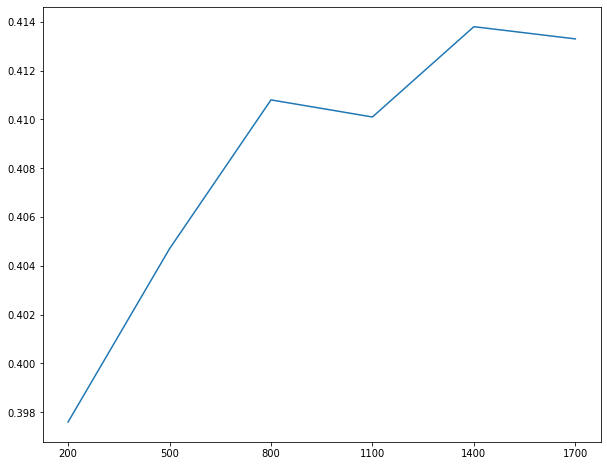

In [21]:
df_batch.loc[0][1:].plot()

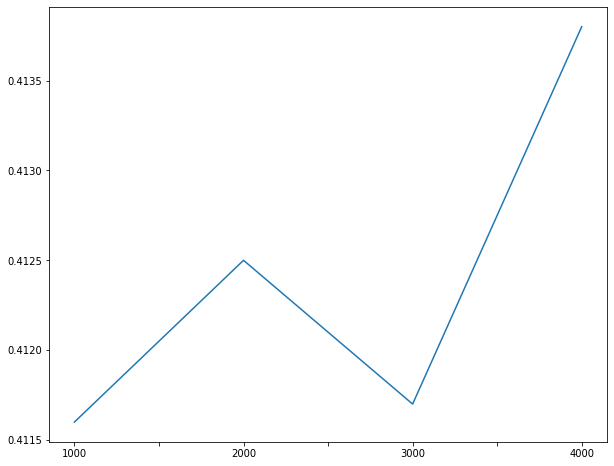

In [22]:
df_iter.loc[0][1:].plot()